# Long range dispersal model

This notebook simulates the evolution of a three-species system  with long-range dispersal.

Importing the necessary libraries:

In [1]:
import numpy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import colormaps
from scipy.integrate import odeint
np.random.seed(0)

## Discrete-time model
### Finite population

We consider a model world that has $N$ available sites. The sites are occupied by three species, namely species $r$ (rock), $s$ (scissors) and $p$ (paper), which occur in the proportions $n_r$ , $n_s$ and $n_p$ (with $n_r + n_s + n_p = 1$). Two sites are chosen at each time-step. The occupant of the first replicates into the second with a given probability - individual of species $r$ can invade a species $s$ with probability $P_r$, a species $s$ invades a species $p$ with probability $P_s$, a species $p$ invades a species $r$ with probability $P_p$ and all other invasion probabilities are zero.

Defining a function to simulate the evolution of the system for a world with $N$ sites:

In [2]:
def simulate_finite_N(Pr, Ps, Pp, nr_init, ns_init, N=1000, epochs=100):
    '''
    Simulate the evolution of a population of three species over time
    on a model world that has N available sites.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    N : int
        The number of sites.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if N < 1:
        raise ValueError('Number of sites must be at least 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    sites = numpy.zeros(N)

    nr = []
    ns = []
    np = []

    r_id = 1
    s_id = 2
    p_id = 3

    # Initialize the sites
    for i in range(N):
        sites[i] = numpy.random.choice([r_id, s_id, p_id], p=[nr_init, ns_init, 1-nr_init-ns_init])

    nr.append(numpy.sum(sites == r_id) / N)
    ns.append(numpy.sum(sites == s_id) / N)
    np.append(numpy.sum(sites == p_id) / N)

    for t in range(1, epochs):
        for step in range(N):
            # choose two random sites
            i = numpy.random.randint(0, N)
            j = numpy.random.randint(0, N)
            
            if sites[i] == r_id and sites[j] == s_id: # rock beats scissors
                if numpy.random.rand() < Pr:
                    sites[j] = r_id
            elif sites[i] == s_id and sites[j] == p_id: # scissors beats paper
                if numpy.random.rand() < Ps:
                    sites[j] = s_id
            elif sites[i] == p_id and sites[j] == r_id: # paper beats rock
                if numpy.random.rand() < Pp:
                    sites[j] = p_id
        
        nr.append(numpy.sum(sites == r_id) / N)
        ns.append(numpy.sum(sites == s_id) / N)
        np.append(numpy.sum(sites == p_id) / N)

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)
            ]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Defining functions to plot the evolution of the system:

In [3]:
def line_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a line plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    ax = df.plot(
        figsize=(12, 4),
        style='o-' if show_markers else '-', color=['tab:red', 'purple', 'gold'],
        title=title,
        xlabel='Time'
    );
    if show_markers:
        for line in ax.get_lines():
            line.set_markeredgecolor('black')

def phase_plot_species_evolution(df, title=None):
    '''
    Plot the evolution of species proportions over time in a phase plot.

    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True, sharex=True)
    cmap = colormaps['Blues']
    colors = cmap(np.linspace(0, 1, (df[df.columns[0]].shape[0]-1))) 
    for i in range(3):
        axs[i].plot(df[df.columns[i]][0:-1], df[df.columns[i]][1:], '-', color='k', zorder=1)
        axs[i].scatter(df[df.columns[i]][0:-1], df[df.columns[i]][1:], c=colors, s=50, zorder=2, edgecolor='black')
        axs[i].set_title(df.columns[i])
    fig.suptitle(title);
    fig.tight_layout()

def ternary_plot_species_evolution(df, title=None, show_markers=True):
    '''
    Plot the evolution of species proportions over time in a ternary plot.
    
    Parameters
    ----------
    df : pd.DataFrame
        A DataFrame containing the species proportions over time.
    title : str
        The title of the plot.
    '''
    fig = px.scatter_ternary(
        df,
        a=df.columns[2],
        b=df.columns[0],
        c=df.columns[1],
        color=df.index,
        color_continuous_scale='blues',
        size_max=10,
        title=title
    )
    if show_markers:
        fig.update_traces(mode='lines+markers', line=dict(color='black', width=1),
            marker=dict(symbol='circle', line=dict(width=1, color='black')))
    else:
        fig.update_traces(mode='lines', line=dict(color='black', width=1))
    fig.update_layout(coloraxis_colorbar=dict(title='Time'))
    fig.show('png')

Simulating the evolution of the system with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, $N = 100$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [4]:
fp_finite_N_df = simulate_finite_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, N=1000, epochs=1000)

Plotting the evolution of the system:

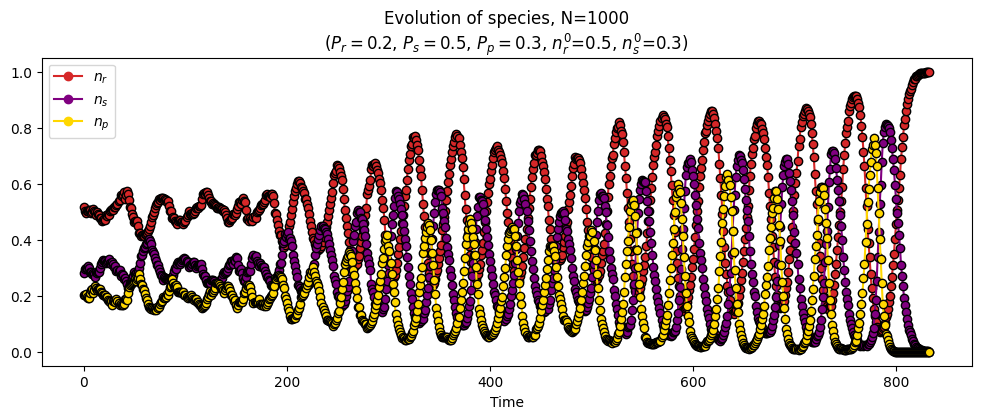

In [5]:
line_plot_species_evolution(
    fp_finite_N_df,
    title='Evolution of species, N=1000\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3)'
)

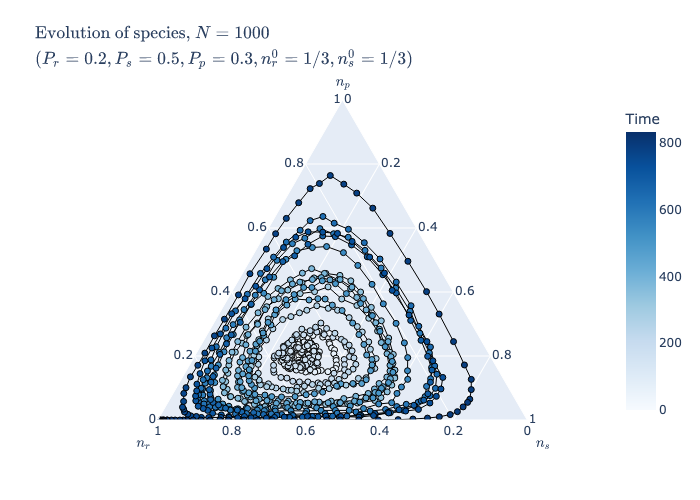

In [6]:
ternary_plot_species_evolution(
    fp_finite_N_df,
    title=r"$\text{Evolution of species, }N=1000\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$"
)

In a finite world, the populations move from orbit to orbit, with two species (scissors and paper) eventually becoming extinct. The species that survives (rock) is the one that has the lowest invasion rate.

Performing simulations for a range of invasion probabilities chosen to sum to unity, initializing the population densities close to the fixed point and recording the surviving species:

In [7]:
# defining a grid of points for invasion probabilities
R, S = np.mgrid[0:1:20j, 0:1:20j]
R, S = R.ravel(), S.ravel()
P = 1 - R - S
I = np.array([R, S, P]).T
# keeping only invasion probabilities greater than 0.01
I = I[np.all(I > 0.01, axis=1)]
R = I[:, 0]
S = I[:, 1]
P = I[:, 2]
# total number of simulations to run
num_sim = len(I)
# number of sites 
N = 1000
# maximum number of iterations
EPOCHS = 2000
# list to store the winner of each simulation
winners = []

# iterating over the invasion probabilities
for i, (Pr, Ps, Pp) in enumerate(I):
    print(f"[{i+1}/{num_sim}] Running simulation for invasion probabilities: Pr={Pr:.2f}, Ps={Ps:.2f}, Pp={Pp:.2f}")
    # simulating with the current invasion probabilities
    results_df = simulate_finite_N(
        Pr=Pr, Ps=Ps, Pp=Pp,
        nr_init=Ps, ns_init=Pp,
        N=N, epochs=EPOCHS
    )
    # storing the winner
    if results_df.index.stop==EPOCHS: # no winner
        winners.append('None')
    elif np.isclose(results_df.iloc[-1]['$n_r$'], 1, 1e-4): # rock wins
            winners.append('Rock')
    elif np.isclose(results_df.iloc[-1]['$n_s$'], 1, 1e-4): # scissors wins
        winners.append('Scissors')
    else: # paper wins
        winners.append('Paper')

[1/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.05, Pp=0.89
[2/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.11, Pp=0.84
[3/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.16, Pp=0.79
[4/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.21, Pp=0.74
[5/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.26, Pp=0.68
[6/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.32, Pp=0.63
[7/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.37, Pp=0.58
[8/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.42, Pp=0.53
[9/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.47, Pp=0.47
[10/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.53, Pp=0.42
[11/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.58, Pp=0.37
[12/153] Running simulation for invasion probabilities: Pr=0.05, Ps=0.63, Pp=0.32
[13/153] Running simulati

Plotting the surviving species on a ternary plot:

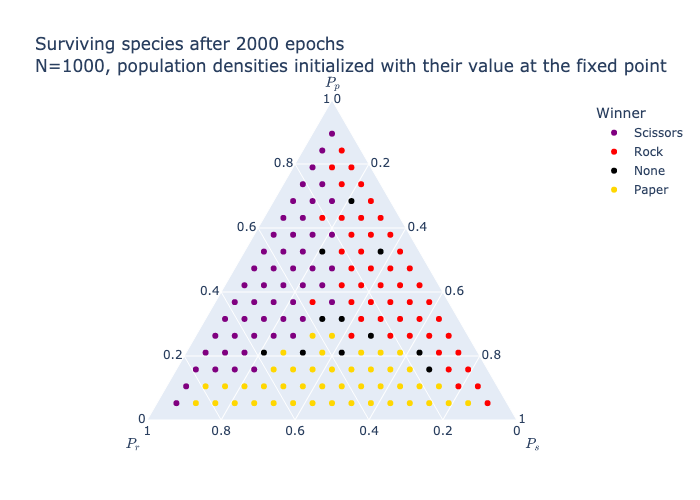

In [8]:
fig = px.scatter_ternary(
    pd.DataFrame(I, columns=['$P_r$', '$P_s$', '$P_p$']),
    a="$P_p$",
    b="$P_r$",
    c="$P_s$",
    size_max=10,
    title=f"Surviving species after {EPOCHS} epochs<br>N={N}, population densities initialized with their value at the fixed point",
    color = winners,
    color_discrete_map={'None': 'black', 'Rock': 'red', 'Scissors': 'purple', 'Paper': 'gold'}
    )
fig.update_layout(legend_title_text='Winner')
fig.show('png')

The weakest competitor is most likely to survive.

### Large population size

In the limit of large $N$, the rate of change of species population density is given by the mean-field equations:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)\\
\frac{\partial n_p}{\partial t}=n_p\cdot (n_r\cdot P_p - n_s \cdot P_s)\\
\end{cases}
Here a unit of time $t$ is $N$ individual time-steps, which we refer to as an epoch.

This leads to the following recurrence equations
$$n_r[t+1]=n_r[t] + n_r[t](n_s[t]P_r - n_p[t] P_p)$$
$$n_s[t+1]=n_s[t] + n_s[t](n_p[t]P_s - n_r[t] P_r)$$
$$n_p[t+1]=n_p[t] + n_p[t](n_r[t]P_p - n_s[t] P_s)$$

Defining a function to simulate the evolution of the system under the large $N$ assumption:

In [9]:
def simulate_large_N(Pr, Ps, Pp, nr_init, ns_init, delta_t=0.001, epochs=1000):
    '''
    Simulate the evolution of a population of three species over time using 
    the recurrence relations under the large N assumption.

    Parameters
    ----------
    Pr : float
        The probability that a species of type r invades a species of type s.
    Ps : float
        The probability that a species of type s invades a species of type p.
    Pp : float
        The probability that a species of type p invades a species of type r.
    nr_init : float
        The initial proportion of species r in the population.
    ns_init : float
        The initial proportion of species s in the population.
    delta_t : float
        The time step size.
    epochs : int
        The number of time units to simulate.
    '''

    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('Pr, Ps and Pp must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)
    
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    if epochs < 1:
        raise ValueError('Number of steps must be at least 1')
    
    nr = []
    ns = []
    np = []

    nr.append(nr_init)
    ns.append(ns_init)
    np.append(1 - nr_init - ns_init)

    for _ in range(0, epochs-1):
        nr.append(nr[-1] + nr[-1]*delta_t*(ns[-1]*Pr - np[-1]*Pp))
        ns.append(ns[-1] + ns[-1]*delta_t*(np[-1]*Ps - nr[-2]*Pr)) # use nr from the previous time step
        np.append(1 - nr[-1] - ns[-1])

        # if two species go extinct, stop the simulation
        if sum([numpy.isclose(nr[-1], 0, 1e-4),
                numpy.isclose(ns[-1], 0, 1e-4),
                numpy.isclose(np[-1], 0, 1e-4)]) >= 2:
            break
    
    return pd.DataFrame({'$n_r$': nr, '$n_s$': ns, '$n_p$': np})

Trivial fixed points of the system are ($n_r=0, n_s=0, n_p=1$), ($n_r=0, n_s=1, n_p=0$) and ($n_r=1, n_s=0, n_p=0$).

The non-trivial fixed point is obtained by setting the rates of change to zero:

\begin{cases}
\frac{\partial n_r}{\partial t}=n_r\cdot (n_s\cdot P_r - n_p \cdot P_p)=0 \implies n_p = \frac{n_s\cdot P_r}{P_p}&\text{(1)}\\
\frac{\partial n_s}{\partial t}=n_s\cdot (n_p\cdot P_s - n_r \cdot P_r)=0 \implies n_r = \frac{n_p\cdot P_s}{P_r}&\text{(2)}\\
n_r+n_s+n_p=1 \implies n_s = 1-n_p-n_r&\text{(3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_r = \frac{n_s \cdot \cancel{P_r}\cdot P_s}{P_p\cdot \cancel{P_r}}&\text{(4), substituting (1) into (2)}\\
n_s = 1-\frac{n_s\cdot P_r}{P_p}-nr&\text{(5), substituting (1) into (3)}\\
\end{cases}

$$\implies$$

\begin{cases}
n_s=1-\frac{n_s\cdot P_r}{P_p}-\frac{n_s\cdot P_s}{P_p}\implies n_s=\frac{P_p}{P_p+P_r+P_s}&\text{(6), substituting (4) into (5)}\\
n_p=\frac{n_s\cdot P_r}{P_p}=\frac{\cancel{P_p}\cdot P_r}{\cancel{P_p}\cdot (P_p+P_r+P_s)}=\frac{P_r}{P_p+P_r+P_s}&\text{(7), substituting (6) into (1)}\\
n_r=\frac{n_p\cdot P_s}{P_r}=\frac{\cancel{P_r}\cdot P_s}{\cancel{P_r}\cdot (P_p+P_r+P_s)}=\frac{P_s}{P_p+P_r+P_s}&\text{(8), substituting (7) into (2)}\\
\end{cases}

In the following, we will refer to the population density at the fixed point as $R$, $S$ and $P$ for species $r$, $s$ and $p$ respectively.

Simulating the evolution of the system under the large N assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [10]:
fp_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3, epochs=100)

Plotting the evolution of the system:

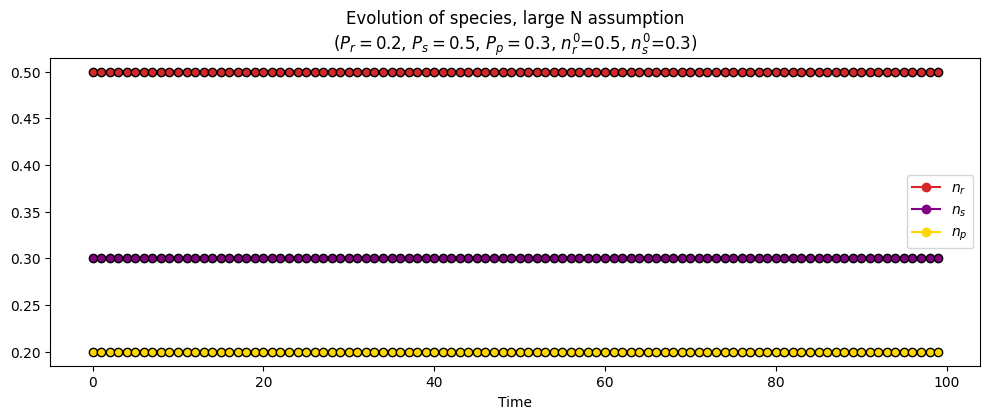

In [11]:
line_plot_species_evolution(
    fp_large_N_df,
    title='Evolution of species, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3)'
)

Initializing the population densities equal to the fixed point ($n_r=1/3$, $n_s=1/3$, $n_p=1/3), the system remains at the fixed point.

Simulating the evolution of the system under the large N assumption with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$) and using $\Delta_t=1$:

In [12]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=1, epochs=1000)

Plotting the evolution of the system:

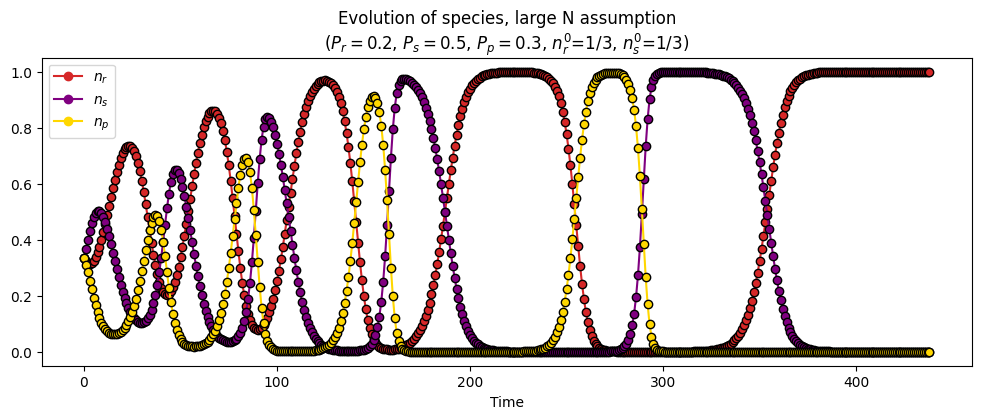

In [13]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Evolution of species, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)'
)

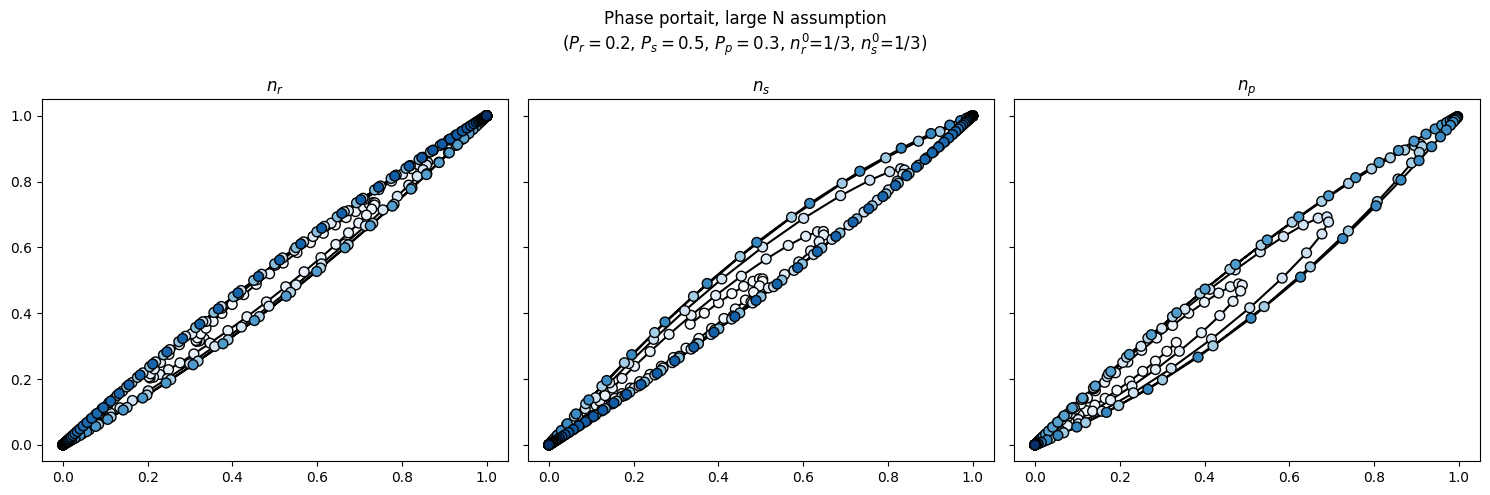

In [14]:
phase_plot_species_evolution(
    eq_large_N_df,
    title='Phase portait, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)'
)

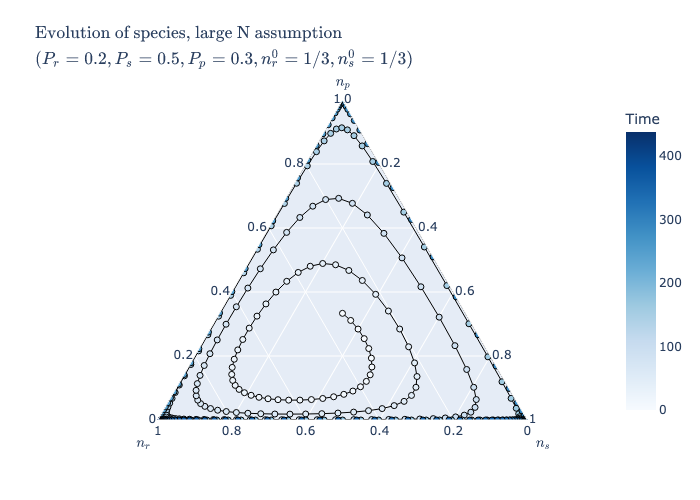

In [15]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Evolution of species, large N assumption}\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$"
)

Simulating the evolution of the system with $\Delta_t=0.01$ to increase accuracy:

In [16]:
eq_large_N_df = simulate_large_N(Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3, delta_t=0.01, epochs=100000)

Plotting the evolution of the system:

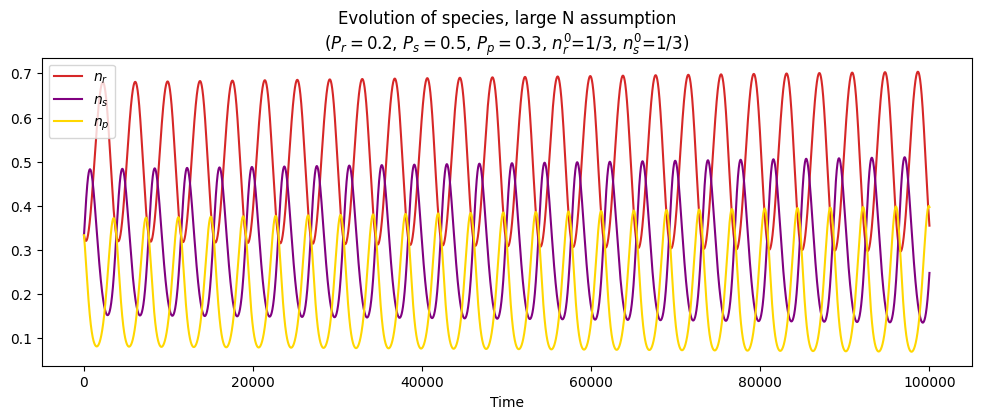

In [17]:
line_plot_species_evolution(
    eq_large_N_df,
    title='Evolution of species, large N assumption\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)',
    show_markers=False
)

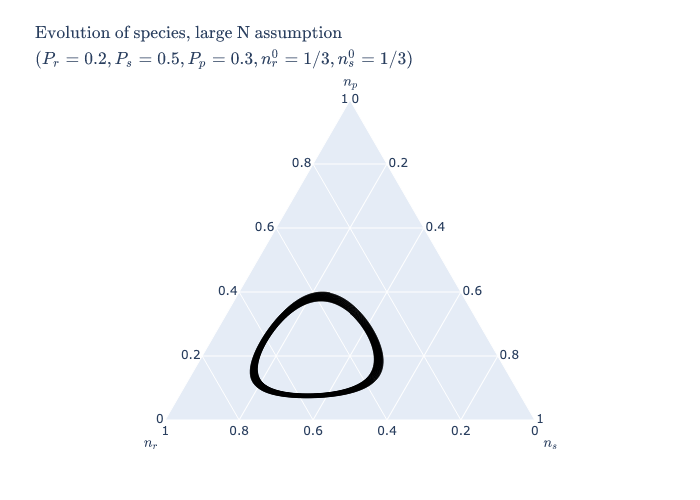

In [18]:
ternary_plot_species_evolution(
    eq_large_N_df,
    title=r"$\text{Evolution of species, large N assumption}\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$",
    show_markers=False
)

In the limit that the total number of sites is large the populations move along a periodic orbit around the fixed point.

## Continuous-time model

To enhance accuracy, we simulate the system's evolution by solving the differential equations that define it.

The `odeint` method from `scipy.integrate` solves a system of ordinary differential equations using lsoda from the FORTRAN library odepack. This library uses the Adams/BDF method with automatic stiffness detection and switching.

In [19]:
def ODE_solver(t, P, x0):
    '''
    Solve the initial value problem for the ODE system.
    '''
    def RSP(x, t, P):
        nr = x[0]
        Pr = P[0]
        ns = x[1]
        Ps = P[1]
        np = 1 - nr - ns
        Pp = P[2]

        d_nr_dt = nr*(ns*Pr - np*Pp)
        d_ns_dt = ns*(np*Ps - nr*Pr)
        return [d_nr_dt, d_ns_dt]

    y = odeint(RSP, x0, t, args=(P,))
    results_df = pd.DataFrame(y, columns=['$n_r$', '$n_s$'])
    results_df['$n_p$'] = 1 - results_df['$n_r$'] - results_df['$n_s$']
    return results_df

def simulate_continuous(t, Pr, Ps, Pp, nr_init, ns_init):
    '''
    Simulate the evolution of a population of three species over time in the
    continuous setting, solving the initial value problem for the ODE system.
    '''
    if nr_init + ns_init > 1:
        raise ValueError('Initial species proportions must be less than 1')
    
    def check_P(P):
        if P < 0 or P > 1:
            raise ValueError('P_r, P_s and P_p must be between 0 and 1')
        
    check_P(Pr)
    check_P(Ps)
    check_P(Pp)

    P = [Pr, Ps, Pp]
    x0 = [nr_init, ns_init]
    s = ODE_solver(t, P, x0)
    return s

Simulating the evolution of the system in the continuous setting with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$ initialized with population densities close to the fixed point ($n_r=0.5$, $n_s=0.3$, $n_p=0.2$):

In [20]:
fp_continuous_df = simulate_continuous(t=np.linspace(0,100,101), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=0.5, ns_init=0.3)

Plotting the evolution of the system:

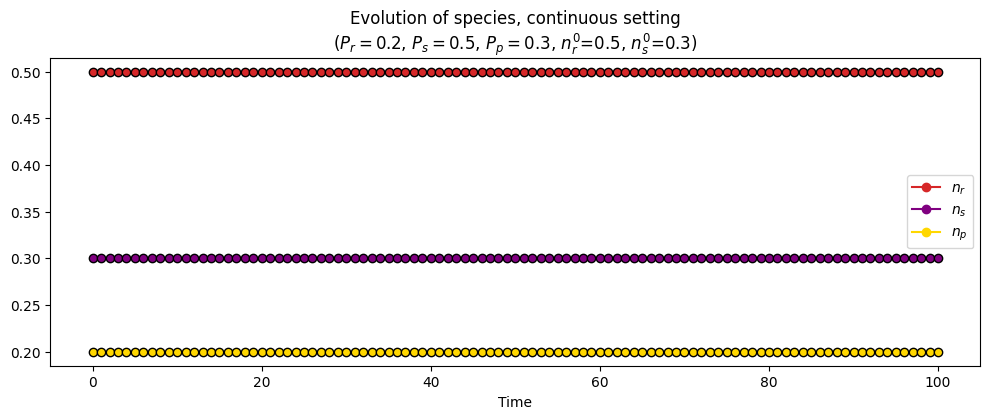

In [21]:
line_plot_species_evolution(
    fp_continuous_df,
    title='Evolution of species, continuous setting\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=0.5, $n_s^0$=0.3)'
)

As in the discrete time setting, initializing the population densities equal to the fixed point ($n_r=1/3$, $n_s=1/3$, $n_p=1/3), the system remains at the fixed point.

Simulating the evolution of the system in the continuous setting with $P_r = 0.2$, $P_s = 0.5$, $P_p = 0.3$, initialized with equal population densities ($n_r=1/3$, $n_s=1/3$, $n_p=1/3$)$:

In [22]:
eq_continuous_df = simulate_continuous(t=np.linspace(0,1000,1001), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=1/3, ns_init=1/3)

Plottting the evolution of the system:

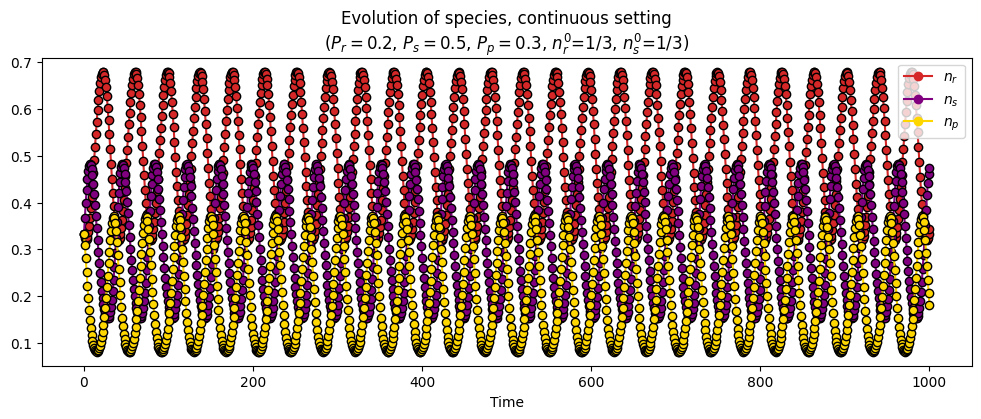

In [23]:
line_plot_species_evolution(
    eq_continuous_df,
    title='Evolution of species, continuous setting\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0$=1/3, $n_s^0$=1/3)'
)

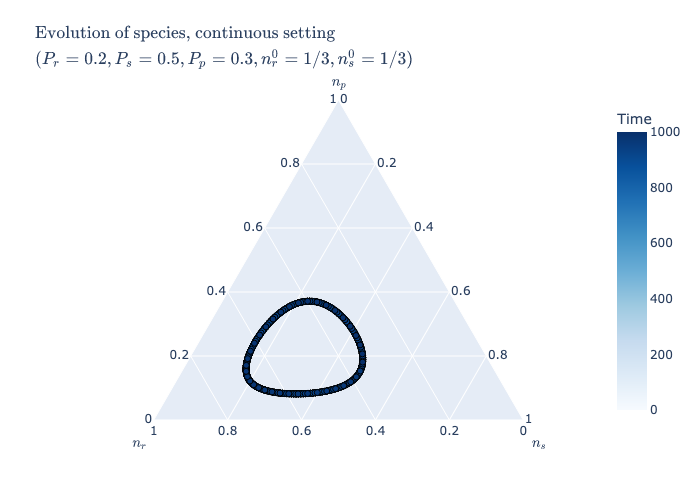

In [24]:
ternary_plot_species_evolution(
    eq_continuous_df,
    title=r"$\text{Evolution of species, continuous setting}\\(P_r=0.2, P_s=0.5, P_p=0.3, n_r^0=1/3, n_s^0=1/3)$"
)

Again, the populations move along a periodic orbit around the fixed point.

Performing simulations for different initial population densities and plotting the orbits on a ternary plot:

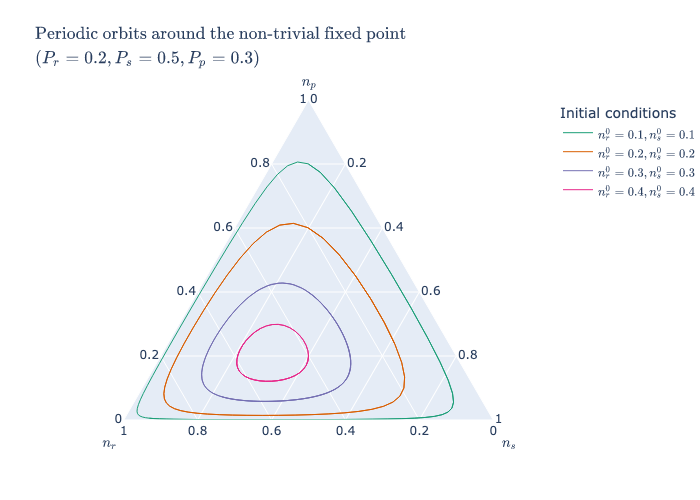

In [25]:
fig = go.Figure()
# iterating over initial proportions
for i, init in enumerate([0.1, 0.2, 0.3, 0.4]):
    # simulate the system
    df = simulate_continuous(t=np.linspace(0,100,101), Pr=0.2, Ps=0.5, Pp=0.3, nr_init=init, ns_init=init)
    # plot the trajectory
    fig.add_trace(go.Scatterternary(
        mode='lines',
        a=df['$n_p$'],
        b=df['$n_r$'],
        c=df['$n_s$'],
        name=f'$n_r^0={init}, n_s^0={init}$',
        line=dict(color=px.colors.qualitative.Dark2[i], width=1)
    ))
fig.update_layout(
    ternary=dict(
        aaxis_title='$n_p$',
        baxis_title='$n_r$',
        caxis_title='$n_s$'
    ),
    title=r"$\text{Periodic orbits around the non-trivial fixed point}\\(P_r=0.2, P_s=0.5, P_p=0.3)$",
    legend=dict(
        title='Initial conditions'
    )
)
fig.show('png')

The quantity $\lambda=(\frac{n_r}{R})^R(\frac{n_s}{S})^S(\frac{n_p}{P})^P$ is invariant along each orbit, with $\lambda=1$ when the populations are at the fixed point and $\lambda=0$ when one or more of the species become extinct. 

Defining a function to calculate the invariant:

In [26]:
def compute_lambda(df, Pr, Ps, Pp):
    df['lambda'] = (df['$n_r$']/0.5)**Ps*(df['$n_s$']/Pp)**Pp*(df['$n_p$']/Pr)**Pr
    return df

Computing and plotting the orbit invariant:

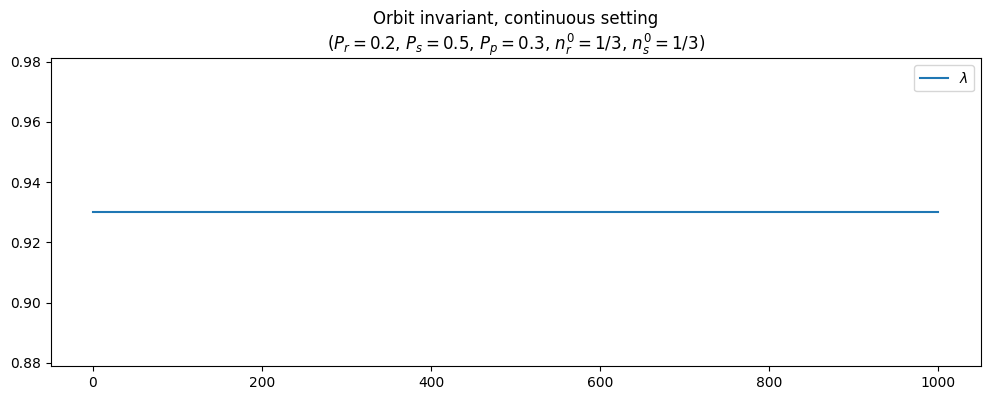

In [27]:
eq_continuous_df = compute_lambda(eq_continuous_df, Pr=0.2, Ps=0.5, Pp=0.3)
eq_continuous_df['lambda'].apply(lambda x: round(x, 2)).plot(
    figsize=(12,4),
    y='lambda',
    style='-', label='$\lambda$',
    title='Orbit invariant, continuous setting\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $n_r^0=1/3$, $n_s^0=1/3$)'
)
plt.legend()

In [28]:
results_df = simulate_continuous(t=np.linspace(0,500,501), Pr=0.1, Ps=0.1, Pp=0.8, nr_init=1/3, ns_init=1/3)

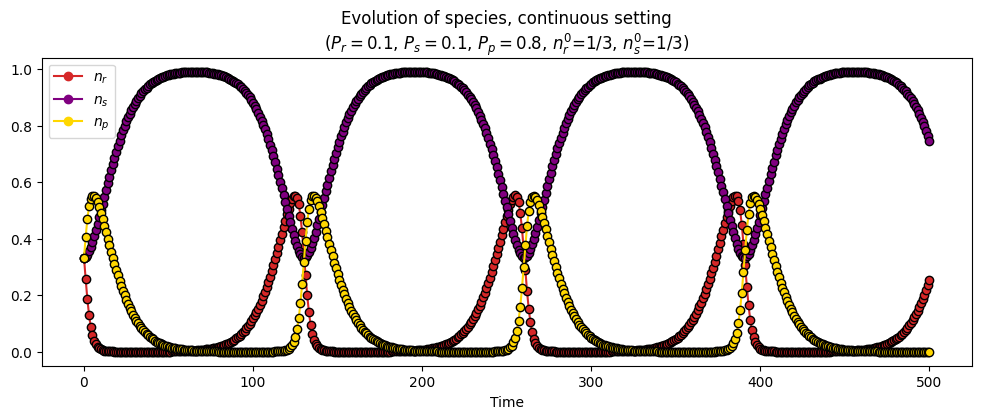

In [29]:
line_plot_species_evolution(
    results_df,
    title='Evolution of species, continuous setting\n($P_r=0.1$, $P_s=0.1$, $P_p=0.8$, $n_r^0$=1/3, $n_s^0$=1/3)'
)

## Stochastic Simulation of Chemical Reactions

To perform stochastic simulations, we need to translate the ODE system

\begin{cases}
\frac{\partial n_r}{\partial t}=\textcolor{violet}{n_r\cdot n_s\cdot P_r} - \textcolor{gold}{n_r \cdot n_p \cdot P_p}\\
\frac{\partial n_s}{\partial t}=\textcolor{cyan}{n_s\cdot n_p\cdot P_s} - \textcolor{orange}{n_s\cdot n_r \cdot P_r}\\
\frac{\partial n_p}{\partial t}=\textcolor{palegreen}{n_p\cdot n_r\cdot P_p} - \textcolor{red}{n_p\cdot n_s \cdot P_s}\\
\end{cases}

into a system of chemical reactions, by constructing one reaction for each term of the equations as follows

\begin{cases}
\textcolor{violet}{R + S \xrightarrow{P_r} S + 2R}\\
\textcolor{gold}{R + P \xrightarrow{P_p} P}\\
\textcolor{cyan}{S + P \xrightarrow{P_s} P + 2S}\\
\textcolor{orange}{S + R \xrightarrow{P_r} R}\\
\textcolor{palegreen}{P + R \xrightarrow{P_p} R + 2P}\\
\textcolor{red}{P + S \xrightarrow{P_s} S}\\
\end{cases}

where we use the capital letters $R, S, P$ to denote the species rock, scissors and paper respectively.

We can simplify the system by noting, for example, that the terms $\textcolor{violet}{n_r\cdot n_s\cdot P_r}$ and $\textcolor{orange}{n_s\cdot n_r \cdot P_r}$ can be represented by the same reaction. Hence we can combine them into a single reaction and do the same for the other similar terms, obtaining the following system

\begin{cases}
R + S \xrightarrow{P_r} 2R\\
S + P \xrightarrow{P_s} 2S\\
P + R \xrightarrow{P_p} 2P\\
\end{cases}

The simplified system clearly represents the interactions between the species: rocks beat scissors with probability $P_r$, scissors beat paper with probability $P_s$ and paper beats rock with probability $P_p$. 

We will use StochPy, a Python package for stochastic simulation of chemical reactions:

In [30]:
import stochpy


#######################################################################
#                                                                     #
#            Welcome to the interactive StochPy environment           #
#                                                                     #
#######################################################################
#  StochPy: Stochastic modeling in Python                             #
#  http://stochpy.sourceforge.net                                     #
#  Copyright(C) T.R Maarleveld, B.G. Olivier, F.J Bruggeman 2010-2015 #
#  DOI: 10.1371/journal.pone.0079345                                  #
#  Email: tmd200@users.sourceforge.net                                #
#  VU University, Amsterdam, Netherlands                              #
#  Centrum Wiskunde Informatica, Amsterdam, Netherlands               #
#  StochPy is distributed under the BSD licence.                      #
###############################################################

StochPy uses the [PySCeS MDL](https://stochpy.sourceforge.net/html/inputfile_doc.html#pysces-inputfile), an ASCII text based input file to describe a system in terms of it’s stoichiometry, kinetics, compartments and parameters. We defined the system using such format and saved it in the file `RSP_model_reduced.psc`:

In [31]:
smod_red_path = 'RSP_model_reduced.psc'

# open and read the file
with open(smod_red_path, 'r') as file:
    content = file.read()

# display the content
print(content)

# Rock Scissors Paper model

# R + S  --> 2R, Pr
# P + R --> 2P, Pp
# S + P --> 2S, Ps

R1:
    R + S > R + R
    R*S*Pr

R2:
    S + P > S + S
    S*P*Ps

R3: 
    P + R > P + P
    P*R*Pp

# Parameters
Pr = 0.2
Ps = 0.5
Pp = 0.3

# Init Values
R = 33
S = 33
P = 33



Loading the model:

In [32]:
smod = stochpy.SSA()
smod.Model(model_file="RSP_model_reduced.psc",dir="./")
smod.ShowSpecies()

['R', 'S', 'P']


Setting initial conditions and parameters, using a high number of copies for each species to approximate the deterministic behavior of the system:

In [33]:
smod.ChangeParameter("Pr", 0.2)
smod.ChangeParameter("Ps", 0.5)
smod.ChangeParameter("Pp", 0.3)
smod.ChangeInitialSpeciesCopyNumber("R", 50000)
smod.ChangeInitialSpeciesCopyNumber("S", 30000)
smod.ChangeInitialSpeciesCopyNumber("P", 20000)

The method to perform a stochastic simulation is `DoStochSim`:

In [34]:
help(smod.DoStochSim)

Help on method DoStochSim in module stochpy.modules.StochSim:

DoStochSim(end=False, mode=False, method=False, trajectories=False, epsilon=0.03, IsTrackPropensities=False, rate_selection=None, species_selection=None, IsOnlyLastTimepoint=False, critical_reactions=[], reaction_orders=False, species_HORs=False, species_max_influence=False, quiet=False) method of stochpy.modules.StochSim.SSA instance
    Run a stochastic simulation for until `end` is reached. This can be either time steps or end time (which could be a *HUGE* number of steps).
    
    Input:
     - *end* [default=1000] (float) simulation end (steps or time)
     - *mode* [default='steps'] (string) simulation mode, can be one of: ['steps','time']
     - *method* [default='Direct'] (string) stochastic algorithm ['Direct', 'FRM', 'NRM', 'TauLeap']
     - *trajectories* [default = 1] (integer)
     - *epsilon* [default = 0.03] (float) parameter for the tau-leap method
     - *IsTrackPropensities* [default = False]
     - *rate

Four stochastic simulation algorithms are available:
- Direct: Direct Stochastic Simulation Algorithm from Gillespie (1977) [1]
- FRM: First Reaction Method from Gillespie (1977) [1]
- NRM: Modified Next Reaction Method from Anderson 2007 [2, 3]
- TauLeap: Tau-leaping Method [4]

Performing a stochastic simulation using default parameters:

/Users/irenetesta/anaconda3/envs/stochpy/lib/python3.11/site-packages/stochpy/modules/Analysis.py:479: UserWarning:

linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "" (-> linestyle='-'). The keyword argument will take precedence.



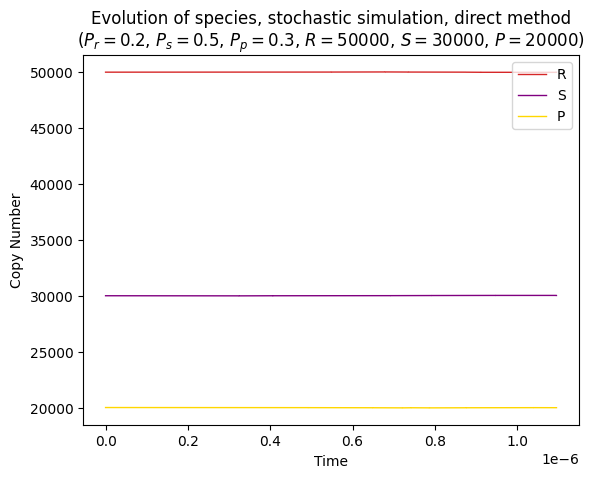

In [35]:
smod.DoStochSim()
smod.PlotSpeciesTimeSeries(colors=["tab:red", "purple", "gold"])
stochpy.plt.title("Evolution of species, stochastic simulation, direct method\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50000$, $S=30000$, $P=20000$)");

As in deterministic simulations, using a high number of molecules and initializing species copy number close to the fixed point, ensures that the system remains at the fixed point.

Performing a stochastic simulation with a lower number of molecules:

In [36]:
smod.ChangeInitialSpeciesCopyNumber("R", 50)
smod.ChangeInitialSpeciesCopyNumber("S", 30)
smod.ChangeInitialSpeciesCopyNumber("P", 20)
smod.DoStochSim(end=10000, IsTrackPropensities=True)
eq_stoch_df = pd.DataFrame(smod.data_stochsim.species, columns=['R', 'S', 'P'])

Plotting the evolution of the system:

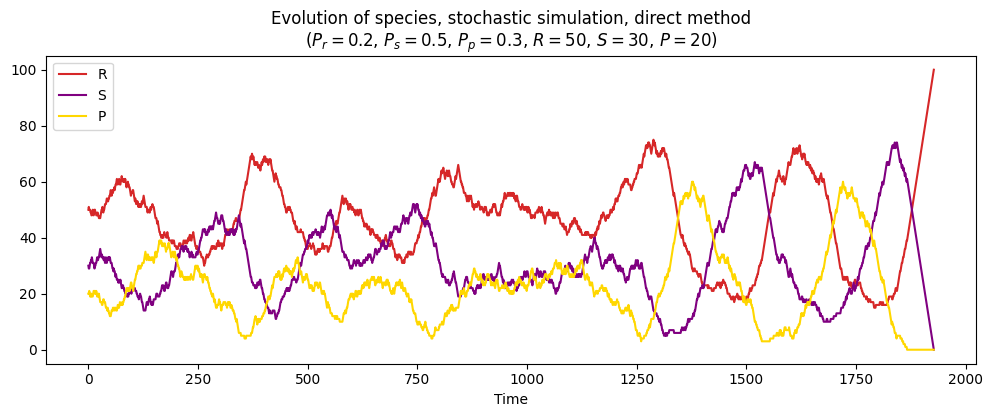

In [37]:
line_plot_species_evolution(
    eq_stoch_df,
    title="Evolution of species, stochastic simulation, direct method\n($P_r=0.2$, $P_s=0.5$, $P_p=0.3$, $R=50$, $S=30$, $P=20$)",
    show_markers=False
)

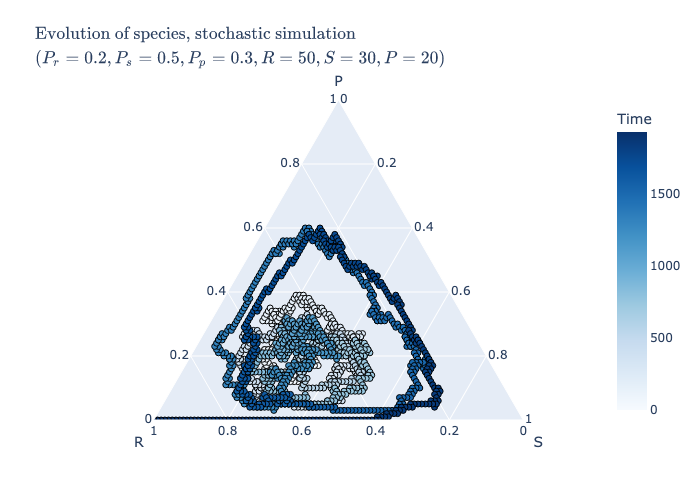

In [38]:
ternary_plot_species_evolution(
    eq_stoch_df,
    title=r"$\text{Evolution of species, stochastic simulation}\\(P_r=0.2, P_s=0.5, P_p=0.3, R=50, S=30, P=20)$"
)

With fewer molecules, two species (scissors and paper) eventually become extinct, and the species that survives (rock) is the one that has the lowest invasion rate, similarly to the discrete-time model with a finite number of sites.

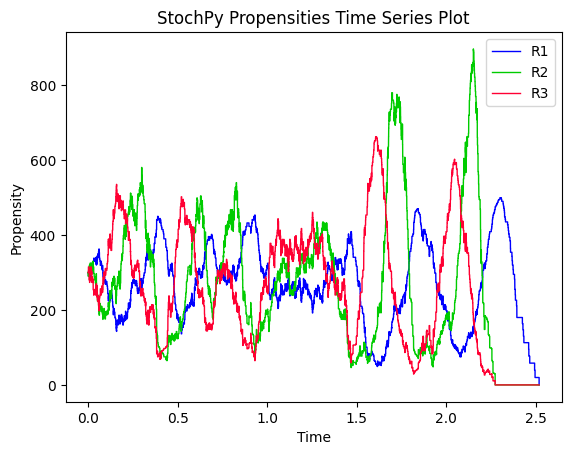

In [39]:
smod.PlotPropensitiesTimeSeries(title='StochPy Propensities Time Series Plot')

*** WARNING ***: No regular grid is created yet. Use GetRegularGrid(n_samples) if averaged results are unsatisfactory (e.g. more or less 'samples')


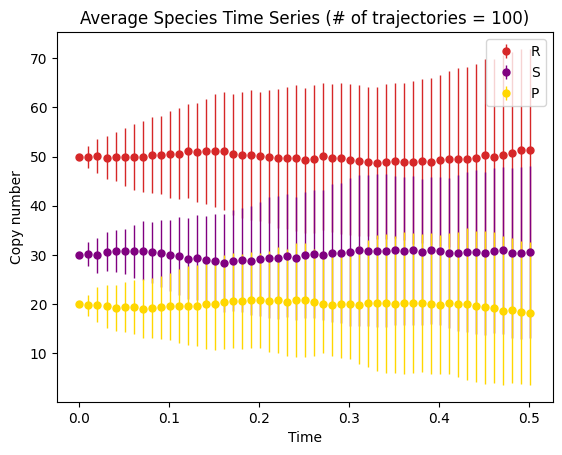

In [40]:
smod.DoStochSim(end=500, trajectories=100, quiet=False)
smod.PlotAverageSpeciesTimeSeries(colors=["tab:red", "purple", "gold"])

## References
- [1] Gillespie D.T "Exact stochastic simulation of coupled chemical reactions", J. Phys. Chem, 1977.
- [2] David F. Anderson "A modified next reaction mehtod for simulating chemical systems with time dependent propensities and delays", J. Phys. Chem, 2007.
- [3] Gibson and Bruck, "Efficient Exact Stochastic Simulation of Chemical Systems with Many Species and Many Channels", J. Phys. Chem, 1999.
- [4] Cao. Y, Gillespie D., Petzold L. "Efficient step size selection for the tau-leaping method", J. Phys. Chem, 2006.